In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


In [2]:
!pip install -U torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 67.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 79.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 7.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 12.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━

In [3]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torchvision.datasets import VOCDetection
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import shutil
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# remove warnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [5]:
print(torch.__version__)
print(torchvision.__version__)

2.4.0+cu121
0.19.0+cu121


In [6]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 7.8 MB/s eta 0:00:00a 0:00:01


In [7]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [9]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(640, 480), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(640, 480), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [10]:
class HumanDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [11]:
dataset_path = "/kaggle/input/cocoset"

In [12]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{0: {'id': 0, 'name': 'human', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'back', 'supercategory': 'human'},
 2: {'id': 2, 'name': 'front', 'supercategory': 'human'},
 3: {'id': 3, 'name': 'side', 'supercategory': 'human'}}

In [13]:
classes = [i[1]['name'] for i in categories.items()]
classes

['human', 'back', 'front', 'side']

In [14]:
train_dataset = HumanDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


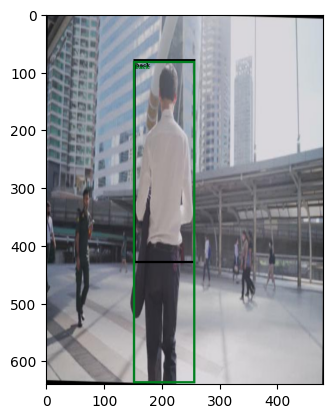

In [15]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [16]:
len(train_dataset)

742

In [17]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 158MB/s] 


In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [19]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [20]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [21]:
device = torch.device("cuda") # use GPU to train

In [22]:
model = model.to(device)

In [23]:
# Now, an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [ ]:
# Or, an alternative optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=1e-4)

# Optional: Learning rate scheduler
# Adjust milestones and gamma as necessary for your training setup
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [24]:
import sys

In [25]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [26]:
num_epochs=100

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


Epoch 0, lr: 0.010000, loss: 1.113373, loss_classifier: 0.471701, loss_box: 0.506302, loss_rpn_box: 0.095948, loss_object: 0.039423


100%|██████████| 47/47 [00:29<00:00,  1.60it/s]


Epoch 1, lr: 0.010000, loss: 0.874351, loss_classifier: 0.351760, loss_box: 0.436112, loss_rpn_box: 0.073470, loss_object: 0.013009


100%|██████████| 47/47 [00:29<00:00,  1.59it/s]


Epoch 2, lr: 0.010000, loss: 0.759227, loss_classifier: 0.265514, loss_box: 0.416544, loss_rpn_box: 0.066582, loss_object: 0.010586


100%|██████████| 47/47 [00:29<00:00,  1.58it/s]


Epoch 3, lr: 0.010000, loss: 0.706235, loss_classifier: 0.223952, loss_box: 0.415222, loss_rpn_box: 0.059441, loss_object: 0.007619


100%|██████████| 47/47 [00:29<00:00,  1.61it/s]


Epoch 4, lr: 0.010000, loss: 0.677372, loss_classifier: 0.204238, loss_box: 0.408560, loss_rpn_box: 0.056941, loss_object: 0.007633


100%|██████████| 47/47 [00:28<00:00,  1.63it/s]


Epoch 5, lr: 0.010000, loss: 0.629746, loss_classifier: 0.184290, loss_box: 0.385374, loss_rpn_box: 0.053157, loss_object: 0.006924


100%|██████████| 47/47 [00:29<00:00,  1.62it/s]


Epoch 6, lr: 0.010000, loss: 0.595440, loss_classifier: 0.174098, loss_box: 0.365254, loss_rpn_box: 0.050163, loss_object: 0.005926


100%|██████████| 47/47 [00:28<00:00,  1.66it/s]


Epoch 7, lr: 0.010000, loss: 0.587128, loss_classifier: 0.163517, loss_box: 0.370385, loss_rpn_box: 0.047843, loss_object: 0.005384


100%|██████████| 47/47 [00:28<00:00,  1.67it/s]


Epoch 8, lr: 0.010000, loss: 0.573297, loss_classifier: 0.163718, loss_box: 0.359110, loss_rpn_box: 0.045582, loss_object: 0.004886


100%|██████████| 47/47 [00:28<00:00,  1.68it/s]


Epoch 9, lr: 0.010000, loss: 0.550304, loss_classifier: 0.150699, loss_box: 0.351606, loss_rpn_box: 0.043304, loss_object: 0.004696


100%|██████████| 47/47 [00:27<00:00,  1.69it/s]


Epoch 10, lr: 0.010000, loss: 0.547431, loss_classifier: 0.148910, loss_box: 0.350892, loss_rpn_box: 0.043166, loss_object: 0.004463


100%|██████████| 47/47 [00:27<00:00,  1.70it/s]


Epoch 11, lr: 0.010000, loss: 0.501770, loss_classifier: 0.131169, loss_box: 0.326109, loss_rpn_box: 0.040377, loss_object: 0.004115


100%|██████████| 47/47 [00:27<00:00,  1.70it/s]


Epoch 12, lr: 0.010000, loss: 0.498528, loss_classifier: 0.132693, loss_box: 0.322220, loss_rpn_box: 0.039731, loss_object: 0.003884


100%|██████████| 47/47 [00:27<00:00,  1.69it/s]


Epoch 13, lr: 0.010000, loss: 0.462095, loss_classifier: 0.123229, loss_box: 0.297666, loss_rpn_box: 0.037725, loss_object: 0.003476


100%|██████████| 47/47 [00:27<00:00,  1.71it/s]


Epoch 14, lr: 0.010000, loss: 0.475867, loss_classifier: 0.125428, loss_box: 0.308976, loss_rpn_box: 0.037653, loss_object: 0.003810


100%|██████████| 47/47 [00:27<00:00,  1.71it/s]


Epoch 15, lr: 0.010000, loss: 0.460753, loss_classifier: 0.122884, loss_box: 0.298066, loss_rpn_box: 0.036132, loss_object: 0.003671


100%|██████████| 47/47 [00:27<00:00,  1.69it/s]


Epoch 16, lr: 0.010000, loss: 0.440774, loss_classifier: 0.117595, loss_box: 0.284611, loss_rpn_box: 0.035401, loss_object: 0.003168


100%|██████████| 47/47 [00:27<00:00,  1.71it/s]


Epoch 17, lr: 0.010000, loss: 0.427121, loss_classifier: 0.110664, loss_box: 0.278715, loss_rpn_box: 0.034511, loss_object: 0.003232


100%|██████████| 47/47 [00:27<00:00,  1.71it/s]


Epoch 18, lr: 0.010000, loss: 0.424573, loss_classifier: 0.111452, loss_box: 0.276991, loss_rpn_box: 0.032834, loss_object: 0.003297


100%|██████████| 47/47 [00:27<00:00,  1.71it/s]


Epoch 19, lr: 0.010000, loss: 0.425748, loss_classifier: 0.113656, loss_box: 0.276296, loss_rpn_box: 0.032722, loss_object: 0.003074


100%|██████████| 47/47 [00:27<00:00,  1.71it/s]


Epoch 20, lr: 0.010000, loss: 0.405606, loss_classifier: 0.104776, loss_box: 0.265081, loss_rpn_box: 0.032679, loss_object: 0.003070


100%|██████████| 47/47 [00:27<00:00,  1.74it/s]


Epoch 21, lr: 0.010000, loss: 0.439304, loss_classifier: 0.111553, loss_box: 0.292375, loss_rpn_box: 0.032313, loss_object: 0.003064


100%|██████████| 47/47 [00:27<00:00,  1.72it/s]


Epoch 22, lr: 0.010000, loss: 0.404361, loss_classifier: 0.109135, loss_box: 0.260894, loss_rpn_box: 0.031532, loss_object: 0.002799


100%|██████████| 47/47 [00:27<00:00,  1.74it/s]


Epoch 23, lr: 0.010000, loss: 0.410765, loss_classifier: 0.106009, loss_box: 0.270594, loss_rpn_box: 0.031606, loss_object: 0.002556


100%|██████████| 47/47 [00:27<00:00,  1.73it/s]


Epoch 24, lr: 0.010000, loss: 0.394824, loss_classifier: 0.102233, loss_box: 0.258864, loss_rpn_box: 0.030783, loss_object: 0.002944


100%|██████████| 47/47 [00:27<00:00,  1.74it/s]


Epoch 25, lr: 0.010000, loss: 0.387026, loss_classifier: 0.101925, loss_box: 0.251745, loss_rpn_box: 0.030791, loss_object: 0.002565


100%|██████████| 47/47 [00:27<00:00,  1.74it/s]


Epoch 26, lr: 0.010000, loss: 0.378348, loss_classifier: 0.105710, loss_box: 0.240238, loss_rpn_box: 0.029689, loss_object: 0.002710


100%|██████████| 47/47 [00:26<00:00,  1.75it/s]


Epoch 27, lr: 0.010000, loss: 0.380745, loss_classifier: 0.100148, loss_box: 0.248952, loss_rpn_box: 0.029311, loss_object: 0.002333


100%|██████████| 47/47 [00:26<00:00,  1.75it/s]


Epoch 28, lr: 0.010000, loss: 0.369006, loss_classifier: 0.097727, loss_box: 0.240267, loss_rpn_box: 0.028747, loss_object: 0.002264


100%|██████████| 47/47 [00:26<00:00,  1.75it/s]


Epoch 29, lr: 0.010000, loss: 0.373483, loss_classifier: 0.095851, loss_box: 0.247552, loss_rpn_box: 0.027733, loss_object: 0.002348


100%|██████████| 47/47 [00:27<00:00,  1.73it/s]


Epoch 30, lr: 0.010000, loss: 0.358887, loss_classifier: 0.091291, loss_box: 0.237931, loss_rpn_box: 0.027397, loss_object: 0.002268


100%|██████████| 47/47 [00:27<00:00,  1.74it/s]


Epoch 31, lr: 0.010000, loss: 0.416779, loss_classifier: 0.131996, loss_box: 0.252839, loss_rpn_box: 0.029476, loss_object: 0.002468


100%|██████████| 47/47 [00:26<00:00,  1.74it/s]


Epoch 32, lr: 0.010000, loss: 0.357896, loss_classifier: 0.097052, loss_box: 0.229390, loss_rpn_box: 0.028120, loss_object: 0.003334


100%|██████████| 47/47 [00:27<00:00,  1.74it/s]


Epoch 33, lr: 0.010000, loss: 0.349538, loss_classifier: 0.094278, loss_box: 0.225433, loss_rpn_box: 0.027513, loss_object: 0.002314


100%|██████████| 47/47 [00:26<00:00,  1.75it/s]


Epoch 34, lr: 0.010000, loss: 0.349728, loss_classifier: 0.092510, loss_box: 0.228531, loss_rpn_box: 0.026599, loss_object: 0.002088


100%|██████████| 47/47 [00:26<00:00,  1.74it/s]


Epoch 35, lr: 0.010000, loss: 0.343987, loss_classifier: 0.087967, loss_box: 0.227169, loss_rpn_box: 0.026746, loss_object: 0.002106


100%|██████████| 47/47 [00:26<00:00,  1.75it/s]


Epoch 36, lr: 0.010000, loss: 0.344723, loss_classifier: 0.087660, loss_box: 0.229272, loss_rpn_box: 0.025748, loss_object: 0.002043


100%|██████████| 47/47 [00:26<00:00,  1.75it/s]


Epoch 37, lr: 0.010000, loss: 0.335421, loss_classifier: 0.084499, loss_box: 0.223020, loss_rpn_box: 0.025907, loss_object: 0.001994


100%|██████████| 47/47 [00:26<00:00,  1.75it/s]


Epoch 38, lr: 0.010000, loss: 0.338477, loss_classifier: 0.085661, loss_box: 0.225399, loss_rpn_box: 0.025323, loss_object: 0.002095


100%|██████████| 47/47 [00:27<00:00,  1.74it/s]


Epoch 39, lr: 0.010000, loss: 0.332661, loss_classifier: 0.085723, loss_box: 0.219435, loss_rpn_box: 0.025399, loss_object: 0.002104


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Epoch 40, lr: 0.010000, loss: 0.337668, loss_classifier: 0.086725, loss_box: 0.224694, loss_rpn_box: 0.024290, loss_object: 0.001959


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Epoch 41, lr: 0.010000, loss: 0.332337, loss_classifier: 0.085365, loss_box: 0.220911, loss_rpn_box: 0.024128, loss_object: 0.001932


100%|██████████| 47/47 [00:26<00:00,  1.76it/s]


Epoch 42, lr: 0.010000, loss: 0.321043, loss_classifier: 0.085509, loss_box: 0.210362, loss_rpn_box: 0.023385, loss_object: 0.001787


100%|██████████| 47/47 [00:26<00:00,  1.76it/s]


Epoch 43, lr: 0.010000, loss: 0.326074, loss_classifier: 0.083272, loss_box: 0.217115, loss_rpn_box: 0.023928, loss_object: 0.001760


100%|██████████| 47/47 [00:26<00:00,  1.76it/s]


Epoch 44, lr: 0.010000, loss: 0.314078, loss_classifier: 0.079540, loss_box: 0.209326, loss_rpn_box: 0.023427, loss_object: 0.001785


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Epoch 45, lr: 0.010000, loss: 0.321456, loss_classifier: 0.083372, loss_box: 0.211989, loss_rpn_box: 0.023961, loss_object: 0.002134


100%|██████████| 47/47 [00:26<00:00,  1.75it/s]


Epoch 46, lr: 0.010000, loss: 0.313693, loss_classifier: 0.080458, loss_box: 0.208167, loss_rpn_box: 0.023259, loss_object: 0.001809


100%|██████████| 47/47 [00:26<00:00,  1.76it/s]


Epoch 47, lr: 0.010000, loss: 0.313512, loss_classifier: 0.081025, loss_box: 0.207612, loss_rpn_box: 0.023028, loss_object: 0.001848


100%|██████████| 47/47 [00:26<00:00,  1.76it/s]


Epoch 48, lr: 0.010000, loss: 0.309637, loss_classifier: 0.076386, loss_box: 0.208689, loss_rpn_box: 0.022811, loss_object: 0.001751


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Epoch 49, lr: 0.010000, loss: 0.315006, loss_classifier: 0.082273, loss_box: 0.208593, loss_rpn_box: 0.022378, loss_object: 0.001761


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 50, lr: 0.010000, loss: 0.318443, loss_classifier: 0.078592, loss_box: 0.215422, loss_rpn_box: 0.022770, loss_object: 0.001659


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Epoch 51, lr: 0.010000, loss: 0.302397, loss_classifier: 0.077181, loss_box: 0.201398, loss_rpn_box: 0.022265, loss_object: 0.001552


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Epoch 52, lr: 0.010000, loss: 0.298873, loss_classifier: 0.078055, loss_box: 0.197092, loss_rpn_box: 0.022064, loss_object: 0.001662


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 53, lr: 0.010000, loss: 0.309085, loss_classifier: 0.078441, loss_box: 0.206985, loss_rpn_box: 0.021934, loss_object: 0.001725


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 54, lr: 0.010000, loss: 0.307903, loss_classifier: 0.076641, loss_box: 0.207530, loss_rpn_box: 0.022145, loss_object: 0.001587


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Epoch 55, lr: 0.010000, loss: 0.294205, loss_classifier: 0.076760, loss_box: 0.194464, loss_rpn_box: 0.021403, loss_object: 0.001578


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Epoch 56, lr: 0.010000, loss: 0.293309, loss_classifier: 0.078832, loss_box: 0.192073, loss_rpn_box: 0.020785, loss_object: 0.001618


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 57, lr: 0.010000, loss: 0.284957, loss_classifier: 0.074828, loss_box: 0.186961, loss_rpn_box: 0.021140, loss_object: 0.002027


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Epoch 58, lr: 0.010000, loss: 0.293428, loss_classifier: 0.074744, loss_box: 0.196172, loss_rpn_box: 0.020929, loss_object: 0.001584


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 59, lr: 0.010000, loss: 0.280598, loss_classifier: 0.071503, loss_box: 0.186884, loss_rpn_box: 0.020660, loss_object: 0.001551


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 60, lr: 0.010000, loss: 0.289124, loss_classifier: 0.074664, loss_box: 0.191801, loss_rpn_box: 0.021056, loss_object: 0.001603


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Epoch 61, lr: 0.010000, loss: 0.277185, loss_classifier: 0.070940, loss_box: 0.185097, loss_rpn_box: 0.019639, loss_object: 0.001508


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 62, lr: 0.010000, loss: 0.270529, loss_classifier: 0.068184, loss_box: 0.180498, loss_rpn_box: 0.020218, loss_object: 0.001630


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 63, lr: 0.010000, loss: 0.294330, loss_classifier: 0.078075, loss_box: 0.194120, loss_rpn_box: 0.020468, loss_object: 0.001667


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 64, lr: 0.010000, loss: 0.287244, loss_classifier: 0.074763, loss_box: 0.190204, loss_rpn_box: 0.020583, loss_object: 0.001694


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Epoch 65, lr: 0.010000, loss: 0.271153, loss_classifier: 0.070380, loss_box: 0.179193, loss_rpn_box: 0.020016, loss_object: 0.001564


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 66, lr: 0.010000, loss: 0.279293, loss_classifier: 0.070985, loss_box: 0.187028, loss_rpn_box: 0.019715, loss_object: 0.001564


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 67, lr: 0.010000, loss: 0.277117, loss_classifier: 0.071104, loss_box: 0.184964, loss_rpn_box: 0.019619, loss_object: 0.001430


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Epoch 68, lr: 0.010000, loss: 0.276239, loss_classifier: 0.071997, loss_box: 0.182885, loss_rpn_box: 0.019800, loss_object: 0.001558


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 69, lr: 0.010000, loss: 0.271919, loss_classifier: 0.070588, loss_box: 0.180619, loss_rpn_box: 0.019305, loss_object: 0.001408


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 70, lr: 0.010000, loss: 0.265702, loss_classifier: 0.068704, loss_box: 0.175947, loss_rpn_box: 0.019403, loss_object: 0.001647


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Epoch 71, lr: 0.010000, loss: 0.265965, loss_classifier: 0.069900, loss_box: 0.175392, loss_rpn_box: 0.019108, loss_object: 0.001565


100%|██████████| 47/47 [00:26<00:00,  1.79it/s]


Epoch 72, lr: 0.010000, loss: 0.270064, loss_classifier: 0.069982, loss_box: 0.179376, loss_rpn_box: 0.019293, loss_object: 0.001413


100%|██████████| 47/47 [00:26<00:00,  1.79it/s]


Epoch 73, lr: 0.010000, loss: 0.268766, loss_classifier: 0.068027, loss_box: 0.181333, loss_rpn_box: 0.018200, loss_object: 0.001205


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 74, lr: 0.010000, loss: 0.270023, loss_classifier: 0.070708, loss_box: 0.178813, loss_rpn_box: 0.018998, loss_object: 0.001504


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 75, lr: 0.010000, loss: 0.259623, loss_classifier: 0.065816, loss_box: 0.173364, loss_rpn_box: 0.018893, loss_object: 0.001550


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 76, lr: 0.010000, loss: 0.257072, loss_classifier: 0.067282, loss_box: 0.169907, loss_rpn_box: 0.018425, loss_object: 0.001460


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 77, lr: 0.010000, loss: 0.248681, loss_classifier: 0.065528, loss_box: 0.163463, loss_rpn_box: 0.018336, loss_object: 0.001354


100%|██████████| 47/47 [00:26<00:00,  1.79it/s]


Epoch 78, lr: 0.010000, loss: 0.251765, loss_classifier: 0.065139, loss_box: 0.167291, loss_rpn_box: 0.018042, loss_object: 0.001293


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 79, lr: 0.010000, loss: 0.272672, loss_classifier: 0.070768, loss_box: 0.181712, loss_rpn_box: 0.018797, loss_object: 0.001394


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 80, lr: 0.010000, loss: 0.257770, loss_classifier: 0.067627, loss_box: 0.170546, loss_rpn_box: 0.018215, loss_object: 0.001381


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Epoch 81, lr: 0.010000, loss: 0.249759, loss_classifier: 0.063955, loss_box: 0.166590, loss_rpn_box: 0.017671, loss_object: 0.001544


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 82, lr: 0.010000, loss: 0.253493, loss_classifier: 0.066993, loss_box: 0.167190, loss_rpn_box: 0.017941, loss_object: 0.001369


100%|██████████| 47/47 [00:26<00:00,  1.80it/s]


Epoch 83, lr: 0.010000, loss: 0.259817, loss_classifier: 0.064520, loss_box: 0.175780, loss_rpn_box: 0.018023, loss_object: 0.001494


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 84, lr: 0.010000, loss: 0.260189, loss_classifier: 0.067050, loss_box: 0.174062, loss_rpn_box: 0.017800, loss_object: 0.001278


100%|██████████| 47/47 [00:26<00:00,  1.79it/s]


Epoch 85, lr: 0.010000, loss: 0.260441, loss_classifier: 0.066424, loss_box: 0.174583, loss_rpn_box: 0.018048, loss_object: 0.001386


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 86, lr: 0.010000, loss: 0.245158, loss_classifier: 0.064748, loss_box: 0.161965, loss_rpn_box: 0.017062, loss_object: 0.001382


100%|██████████| 47/47 [00:26<00:00,  1.79it/s]


Epoch 87, lr: 0.010000, loss: 0.251119, loss_classifier: 0.065089, loss_box: 0.167099, loss_rpn_box: 0.017555, loss_object: 0.001377


100%|██████████| 47/47 [00:26<00:00,  1.79it/s]


Epoch 88, lr: 0.010000, loss: 0.246153, loss_classifier: 0.065617, loss_box: 0.162322, loss_rpn_box: 0.016979, loss_object: 0.001235


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


Epoch 89, lr: 0.010000, loss: 0.256529, loss_classifier: 0.066279, loss_box: 0.171560, loss_rpn_box: 0.017298, loss_object: 0.001392


100%|██████████| 47/47 [00:26<00:00,  1.80it/s]


Epoch 90, lr: 0.010000, loss: 0.253536, loss_classifier: 0.064495, loss_box: 0.170069, loss_rpn_box: 0.017816, loss_object: 0.001156


100%|██████████| 47/47 [00:26<00:00,  1.79it/s]


Epoch 91, lr: 0.010000, loss: 0.244042, loss_classifier: 0.062473, loss_box: 0.162800, loss_rpn_box: 0.017340, loss_object: 0.001428


100%|██████████| 47/47 [00:26<00:00,  1.79it/s]


Epoch 92, lr: 0.010000, loss: 0.243093, loss_classifier: 0.062433, loss_box: 0.162292, loss_rpn_box: 0.016985, loss_object: 0.001383


100%|██████████| 47/47 [00:26<00:00,  1.79it/s]


Epoch 93, lr: 0.010000, loss: 0.248725, loss_classifier: 0.063709, loss_box: 0.166517, loss_rpn_box: 0.017155, loss_object: 0.001343


100%|██████████| 47/47 [00:26<00:00,  1.80it/s]


Epoch 94, lr: 0.010000, loss: 0.245886, loss_classifier: 0.063159, loss_box: 0.164521, loss_rpn_box: 0.016780, loss_object: 0.001426


100%|██████████| 47/47 [00:26<00:00,  1.79it/s]


Epoch 95, lr: 0.010000, loss: 0.242062, loss_classifier: 0.063172, loss_box: 0.160479, loss_rpn_box: 0.017059, loss_object: 0.001353


100%|██████████| 47/47 [00:26<00:00,  1.80it/s]


Epoch 96, lr: 0.010000, loss: 0.243380, loss_classifier: 0.062401, loss_box: 0.162885, loss_rpn_box: 0.016600, loss_object: 0.001494


100%|██████████| 47/47 [00:26<00:00,  1.79it/s]


Epoch 97, lr: 0.010000, loss: 0.238377, loss_classifier: 0.059389, loss_box: 0.161547, loss_rpn_box: 0.016136, loss_object: 0.001305


100%|██████████| 47/47 [00:26<00:00,  1.80it/s]


Epoch 98, lr: 0.010000, loss: 0.245262, loss_classifier: 0.062072, loss_box: 0.165315, loss_rpn_box: 0.016602, loss_object: 0.001273


100%|██████████| 47/47 [00:26<00:00,  1.79it/s]

Epoch 99, lr: 0.010000, loss: 0.235644, loss_classifier: 0.061881, loss_box: 0.156178, loss_rpn_box: 0.016266, loss_object: 0.001319


In [27]:
# we will watch first epoch to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [28]:
test_dataset = HumanDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [29]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

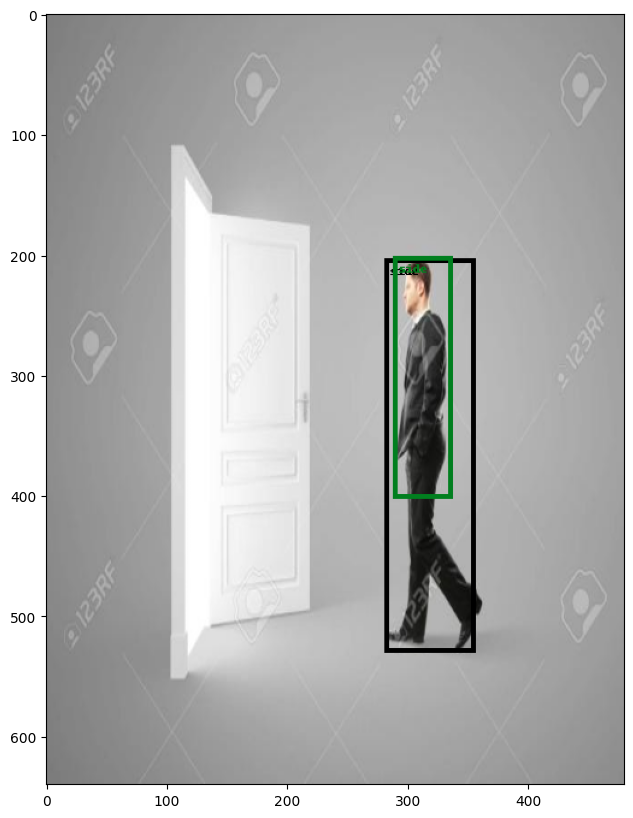

In [30]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [31]:
def get_predictions(model, data_loader, device, threshold=0.5):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for target, output in zip(targets, outputs):
                gt_labels = target['labels'].tolist()
                true_labels.extend(gt_labels)
                
                # Filter predictions based on threshold
                keep = output['scores'] > threshold
                pred_labels_batch = output['labels'][keep].tolist()
                
                # Pad missing predictions with a default class (e.g., 0)
                if len(pred_labels_batch) < len(gt_labels):
                    pred_labels_batch.extend([0] * (len(gt_labels) - len(pred_labels_batch)))
                elif len(pred_labels_batch) > len(gt_labels):
                    pred_labels_batch = pred_labels_batch[:len(gt_labels)]
                
                pred_labels.extend(pred_labels_batch)

    return true_labels, pred_labels

# Load the test dataset
test_dataset = HumanDetection(root=dataset_path, split="test", transforms=get_transforms(False))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

# Get predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
true_labels, pred_labels = get_predictions(model, test_loader, device)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


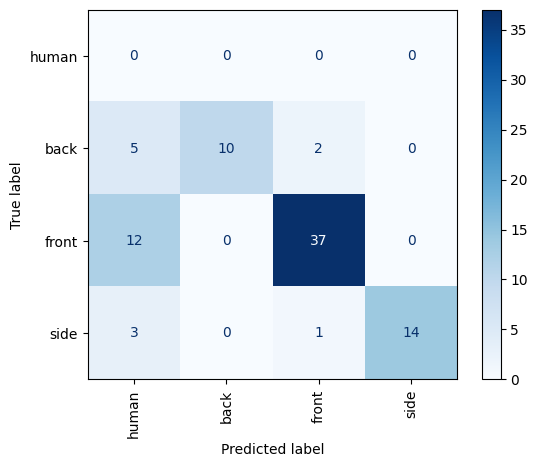

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    
    plt.savefig('confusion_matrix.png')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(true_labels, pred_labels, classes)


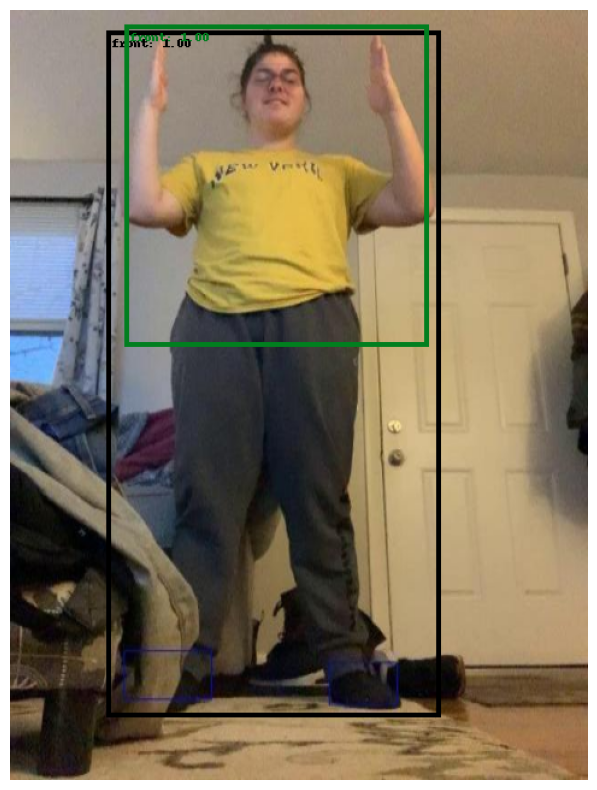

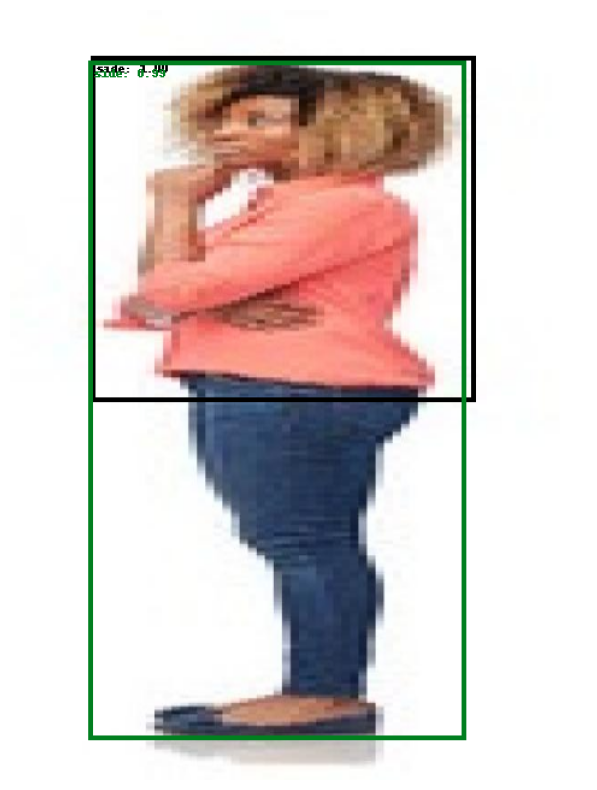

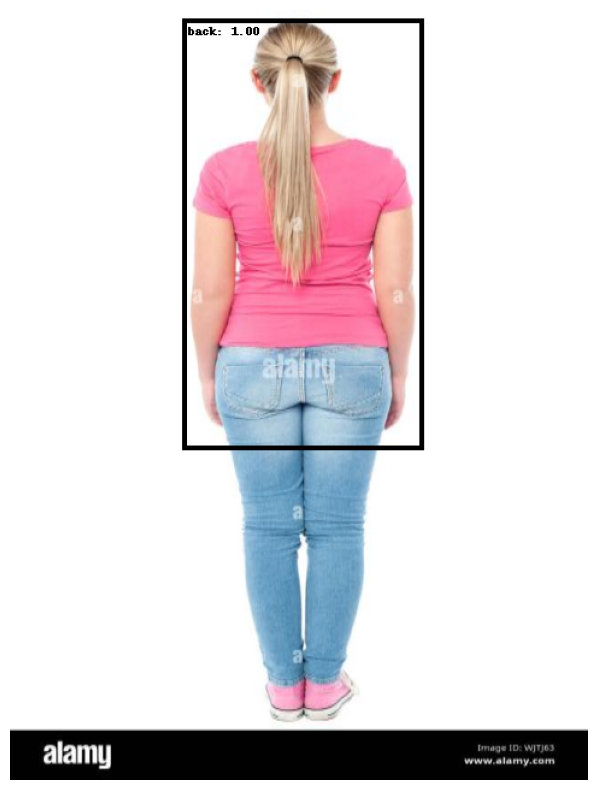

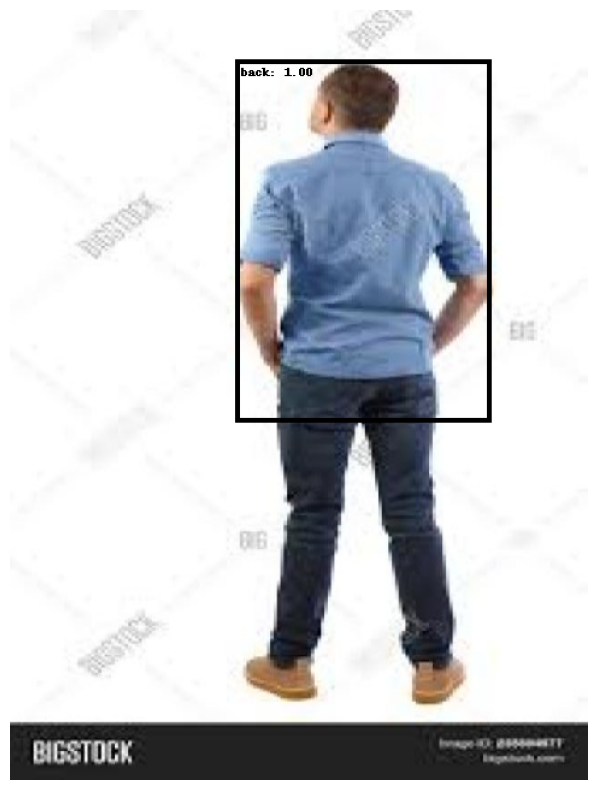

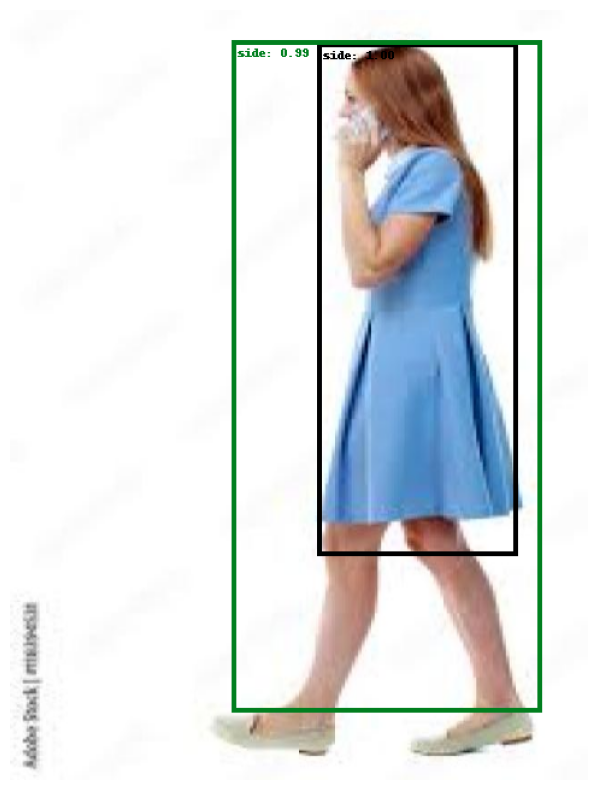

In [33]:
def visualize_predictions(model, dataset, device, num_images=5, score_threshold=0.5):
    model.eval()
    images, predictions = [], []

    with torch.no_grad():
        for i in range(num_images):
            img, _ = dataset[i]
            img = img.to(device)
            prediction = model([img])[0]

            images.append(img.cpu())
            predictions.append(prediction)

    for img, pred in zip(images, predictions):
        img_int = torch.tensor(img * 255, dtype=torch.uint8)
        keep = pred['scores'] > score_threshold
        boxes = pred['boxes'][keep]
        labels = pred['labels'][keep]
        scores = pred['scores'][keep]

        plt.figure(figsize=(10, 10))
        plt.imshow(draw_bounding_boxes(
            img_int, boxes, [f"{classes[i]}: {s:.2f}" for i, s in zip(labels, scores)], width=4
        ).permute(1, 2, 0))
        plt.axis('off')
        plt.show()

# Visualize predictions
visualize_predictions(model, test_dataset, device, num_images=5)


In [34]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_acc, val_acc, output_path):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Save the plot to the specified path
    plt.savefig(output_path)
    plt.close()

# Example data (replace with your actual data)
train_losses = [0.9, 0.7, 0.6, 0.5]  # Replace with your training loss data
val_losses = [0.8, 0.75, 0.65, 0.6]  # Replace with your validation loss data
train_acc = [0.7, 0.8, 0.85, 0.9]  # Replace with your training accuracy data
val_acc = [0.75, 0.78, 0.82, 0.85]  # Replace with your validation accuracy data

# Define the output path
output_path = '/kaggle/working/training_history.png'

# Plot and save the training history
plot_training_history(train_losses, val_losses, train_acc, val_acc, output_path)

# Verify the file is saved correctly
!ls /kaggle/working/


confusion_matrix.png  training_history.png


In [35]:
import shutil

# Save the model weights
torch.save(model.state_dict(), 'best_model.pth')

In [36]:
# Move the file to Kaggle working directory
shutil.move('best_model.pth', '/kaggle/working/best_model.pth')

'/kaggle/working/best_model.pth'

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, output_path):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    
    plt.savefig(output_path)
    plt.close()

# Define the output path
output_path = '/kaggle/working/confusion_matrix.png'

# Plot and save the confusion matrix
plot_confusion_matrix(true_labels, pred_labels, classes, output_path)

# Verify the file is saved correctly
!ls /kaggle/working/


best_model.pth	confusion_matrix.png  training_history.png
